In [3]:
# Basic NGSolve things
from netgen.csg import *
from ngsolve import *
from ngsolve.webgui import Draw

import matplotlib.pyplot as plt
import numpy as np
from read_gmsh3D import ReadGmsh
mesh = Mesh(ReadGmsh('data/small_features/geometry/gmsh2.msh'))
# mesh = Mesh(ReadGmsh('data/small_features/geometry/gmsh.msh'))

mesh.ngmesh.SetBCName(2, "inflow")
mesh.ngmesh.SetBCName(3, "outflow")
for i in range(8):
    mesh.ngmesh.SetBCName(i+6, "frac")    

V = Compress(SurfaceL2(mesh, order=0, definedon=mesh.Boundaries("frac")))
print("matrix elements: ", mesh.ne, "; fracture elements: ", V.ndof)

import matplotlib 
matplotlib.rcParams.update({'font.size': 18})

# %matplotlib inline
import compare_my_method
plt.rc('text', usetex=False) # don't use Latex as Binder currently fails, see https://github.com/jupyterhub/binderhub/issues/1143

matrix elements:  147702 ; fracture elements:  9441


#  Hybrid-Mixed

matrix elements:  31812 ; fracture elements:  3961


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'd…

NE:  31812 NDOF-g:  83022 NDOF-M: 65049 NDOF-Vf:  11883 NDOF-Mf:  6090 NDOF-l: 159060
matrix elements:  147702 ; fracture elements:  9441


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'd…

NE:  147702 NDOF-g:  343359 NDOF-M: 300643 NDOF-Vf:  28323 NDOF-Mf:  14393 NDOF-l: 738510


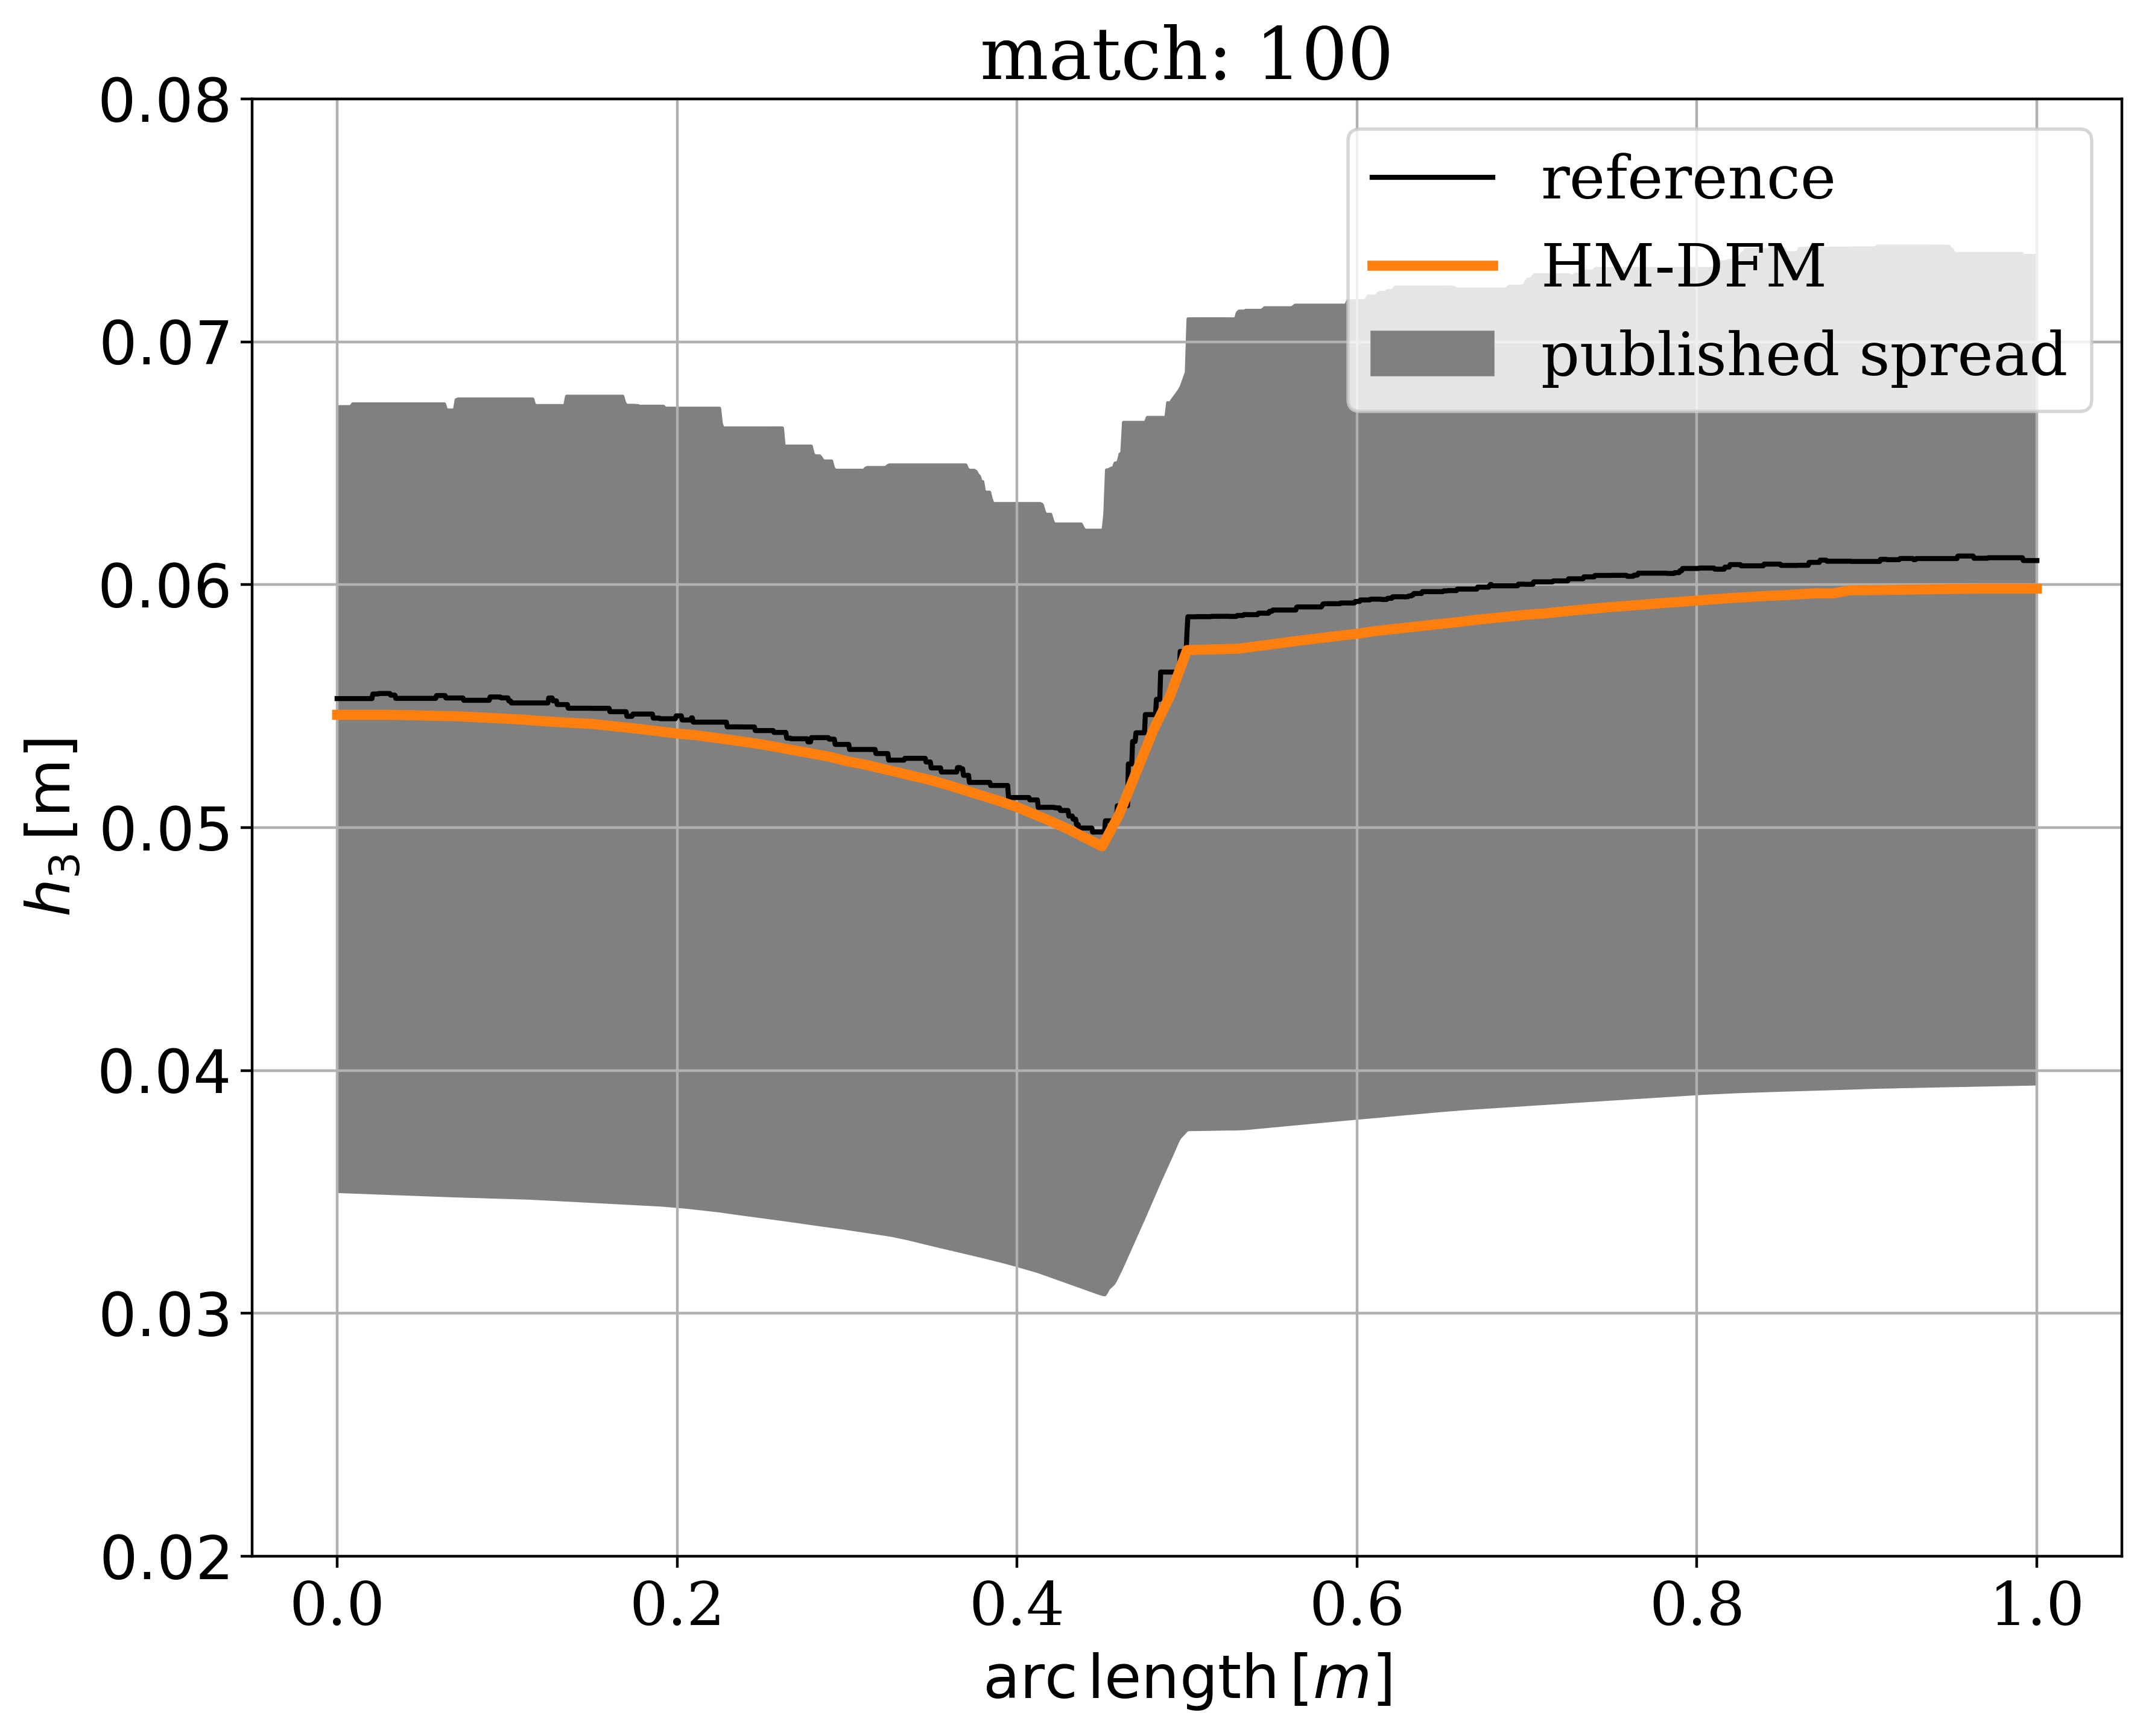

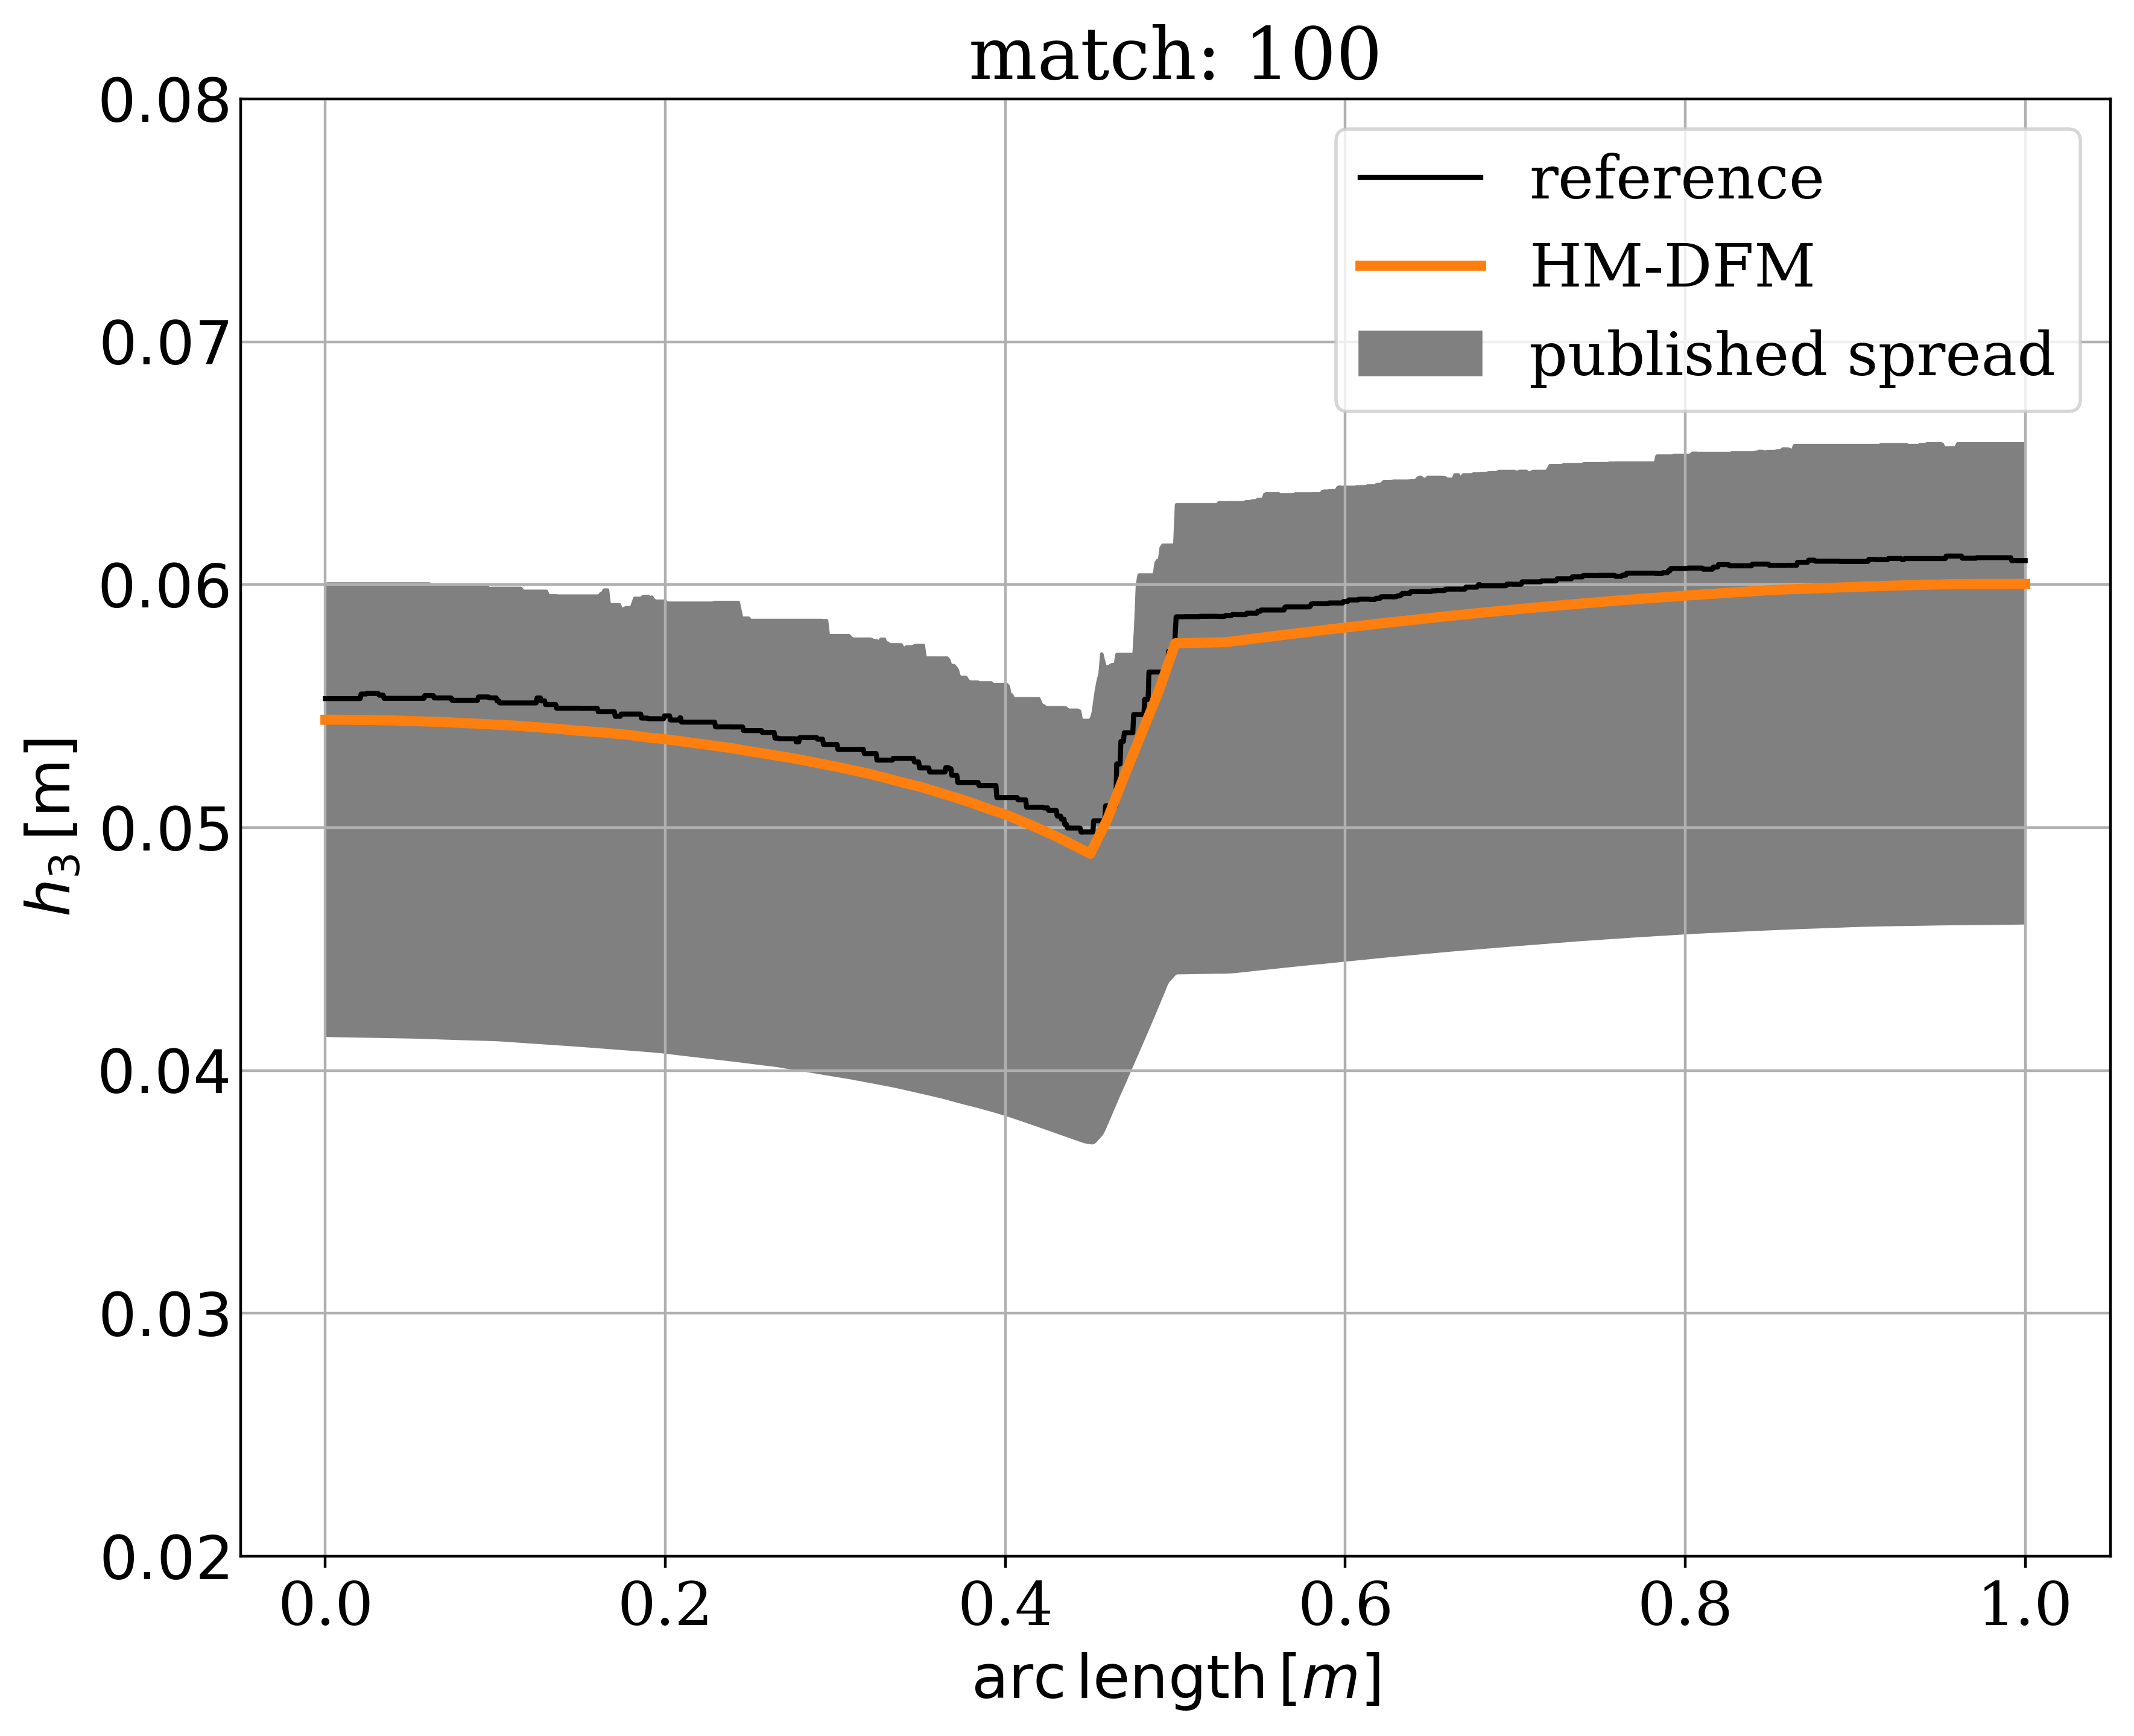

In [4]:
K0, epsK1 = 1, 100
for i in range(2):
    if i == 0:
        mesh = Mesh(ReadGmsh('data/small_features/geometry/gmsh.msh'))
    else:
        mesh = Mesh(ReadGmsh('data/small_features/geometry/gmsh2.msh'))
    mesh.ngmesh.SetBCName(2, "inflow")
    mesh.ngmesh.SetBCName(3, "outflow")
    for j in range(8):
        mesh.ngmesh.SetBCName(j+6, "frac")    
    
    V = Compress(SurfaceL2(mesh, order=0, definedon=mesh.Boundaries("frac")))
    print("matrix elements: ", mesh.ne, "; fracture elements: ", V.ndof)

    order = 0
    frac = "frac"
    V = Discontinuous(HDiv(mesh, order=order, RT=True))
    W = L2(mesh, order=order)
    M = FacetFESpace(mesh, order=order)
    Vf = Discontinuous(HDivSurface(mesh, order=order, RT=True), BND=True)
    for el in Vf.Elements(BND):
        if el.mat =="frac":
            for dof in el.dofs:
                Vf.FreeDofs()[dof] = True
                Vf.SetCouplingType(dof, COUPLING_TYPE.INTERFACE_DOF)
        else:
            for dof in el.dofs:
                Vf.FreeDofs()[dof] = False
                Vf.SetCouplingType(dof, COUPLING_TYPE.UNUSED_DOF)
    Vf = Compress(Vf)

    Mf = Compress(HCurl(mesh, order=order, definedon=mesh.Boundaries(frac))) # hacker?!

    fes = V*W*M*Vf*Mf


    h = specialcf.mesh_size
    n = specialcf.normal(3)
    t = specialcf.tangential(3)
    con = Cross(n,t) # co-normal
    t0 = specialcf.tangential(3,True)

    (u, p, phat, uf, pbar0), (v, q, qhat, vf, qbar0) = fes.TnT()
    pbar = pbar0.Trace()*t0
    qbar = qbar0.Trace()*t0

    condense=True
    a = BilinearForm(fes, condense=condense)
    helper = IfPos((z-1/3)*(z-2/3), 1, 0)

    # subdomain 1
    a += (1/K0*u*v-p*div(v)-q*div(u))*dx
    a += (1/epsK1*uf.Trace()*vf.Trace()-phat.Trace()*div(vf).Trace()-qhat.Trace()*div(uf).Trace()
         )*ds("frac")
    a += (v*n*phat+u*n*qhat)*dx(element_boundary=True)
    a += (vf.Trace()*con*pbar+uf.Trace()*con*qbar)*ds(element_boundary=True, definedon=mesh.Boundaries("frac"))
    a += -1e8*helper*phat.Trace()*qhat.Trace()*ds("outflow") # dirichlet bc hacker

    f = LinearForm(fes)
    f += -(1-helper)*qhat.Trace()*ds("inflow")
    gfu = GridFunction(fes)
    a.Assemble()
    f.Assemble()

    if condense==True:
        f.vec.data += a.harmonic_extension_trans * f.vec
    gfu.vec.data = a.mat.Inverse(fes.FreeDofs(condense), inverse="pardiso")*f.vec
    if condense==True:
        gfu.vec.data += a.harmonic_extension * gfu.vec 
        gfu.vec.data += a.inner_solve * f.vec

    # Local postprocessing
    V2 = L2(mesh, order=order+1, all_dofs_together=False)
    ph = GridFunction(V2)

    a2 = BilinearForm(V2)
    f2 = LinearForm(V2)

    p2, q2 = V2.TnT()
    a2 += grad(p2)*grad(q2)*dx
    a2.Assemble()
    f2 += -1/K0*gfu.components[0]*grad(q2)*dx
    f2.Assemble()

    V2.FreeDofs()[:mesh.ne]=False
    ph.vec[:mesh.ne].data=gfu.components[1].vec[:mesh.ne]
    ph.vec.data += a2.mat.Inverse(V2.FreeDofs())*f2.vec

    gfInterp = GridFunction(H1(mesh, order=order+1))
    gfInterp.Set(ph)
    Draw(gfInterp, mesh, "soln")

    ng = sum(fes.FreeDofs(True))
    nt = sum(fes.FreeDofs())
    print("NE: ", mesh.ne, "NDOF-g: ", ng, "NDOF-M:", sum(M.FreeDofs(True)), 
          "NDOF-Vf: ", sum(Vf.FreeDofs(True)), "NDOF-Mf: ", sum(Mf.FreeDofs(True)), "NDOF-l:", nt-ng)
    # data visualization over line
    xx = np.linspace(0, 1, 101)
    h = np.array([ph(mesh(0.5, 1.1, x)) for x in xx])

    case = 3
    plt.figure(figsize=(10,8), dpi=400)
    plot_id = "a"
    ref_index = i
    subdomain_id = 0
    compare_my_method.evaluate(xx, h, case, plot_id, ref_index, subdomain_id, name="HM-DFM")
    plt.axis([-0.05,1.05, 0.02,0.08])
    plt.savefig("data/smallC"+str(i+1)+".pdf", dpi=400,bbox_inches='tight')